# Colonia de Hormigas
El objetivo de esta práctica es estudiar el funcionamiento de los Algoritmos de Optimización Basados en Colonias de Hormigas (OCH). Para ello, se requerirá que el alumno implemente distintas variantes de estos algoritmos, correspondientes al Sistema de Hormigas (SH) y Sistema de Hormigas Elitista (SHE)), para resolver el problema del Viajante de Comercio. El comportamiento de los algoritmos de OCH implementados deberá compararse con un algoritmo greedy.

## Problema
El Problema del Viajante de Comercio (TSP) es uno de los problemas de optimización combinatoria más conocidos. En su formulación más general, dadas una serie de ciudades, el objetivo consiste en encontrar el circuito de menor coste que parta de una ciudad concreta, pase por todas las demás una sola vez y retorne a la ciudad de origen.

En nuestro caso trabajaremos con instancias estándar del problema (dos data sets modelo), obtenidas de la biblioteca TSPLIB, todas ellas correspondientes al TSP simétrico. Éstas son: • C130 Tamaño 130 ciudades. Coste de la solución óptima: 6.110 • A280 Tamaño 280 ciudades. Coste de la solución óptima: 2.579

Todos estos ficheros presentan el mismo formato, una lista con dos valores para cada ciudad que representan sus coordenadas en el plano. Para componer la matriz de costes se deberá calcular la distancia euclídea entre cada par de ciudades (i, j). Los costos obtenidos han de ser números enteros, es decir, no se considerarán decimales. Así, la matriz de distancias se calcularía de la siguiente forma:
xd = x[i] - x[j];
yd = y[i] - y[j];
dij = rint( sqrt( xdxd + ydyd ) );

donde rint es la función de redondeo y sqrt es la raíz cuadrada.

El alumno implementará el SH (Sistema de Hormigas) y SHE (Sistema de Hormigas Elitista) para resolver el problema, con los distintos data sets.

## Librerías

In [52]:
import random
import numpy as np
import copy

# Graphs and Plots
import matplotlib.pyplot as plt
from PIL import Image

import statistics

import pandas as pd

import os

import math

import time
import timeit

# Barra de progreso
from tqdm import tqdm

## Parámetros

### Semillas

In [72]:
# Establecer semillas

semilla_1 = 9244889
semilla_2 = 6885052
semilla_3 = 1689685
#semilla_4 = 2674794
#semilla_5 = 3656827

# semillas = [semilla_1, semilla_2, semilla_3, semilla_4, semilla_5]

semillas = [semilla_1, semilla_2, semilla_3]


### Algoritmos

In [54]:
greedy_name = "Greedy"
sh_name = "Sistema de Hormigas"
she_name = "Sistema de Hormigas Elitista"

### Parámetros problema

In [55]:
n_hormigas = 30

tiempo_max_c130 = 3 * 60
tiempo_max_a280 = 8 * 60

alpha = 1
beta = 2

n_elitistas = 15

parametro_evaporacion = 0.1

cantidad_feronoma_0 = 0 # 1 / (n · L)
# τ0 = 1 / (n · L), siendo n el tamaño de la instancia del problema y L el coste del circuito devuelto por la heurística greedy implementada.

## Funciones auxiliares

### Leer fichero
La función recibe el nombre del archivo que contiene los datos del TSP y devuelve una lista de coordenadas para cada ciudad.

In [56]:
def cargar_datos(nombre_archivo):
    with open(nombre_archivo) as archivo:
        lineas = archivo.readlines()

    num_ciudades = int(lineas[3].split()[1])
    datos_ciudades = []
    for i in range(6, 6 + num_ciudades):
        ciudad_actual = list(map(float, lineas[i].split()[1:]))
        datos_ciudades.append(ciudad_actual)

    return datos_ciudades

### Leer fichero camino optimo


In [57]:
def leer_path_optimo(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()

    path = []
    start = False
    for line in lines:
        if line.startswith("TOUR_SECTION"):
            start = True
            continue
        elif line.startswith("-1"):
            break
        elif start:
            for value in map(int, line.strip().split()):
                if isinstance(value, int):
                    path.append(value-1)

    return path

### Calcular matriz de distancias
La función recibe la lista de coordenadas para cada ciudad y devuelve la matriz de distancias. En este caso, se utiliza la función round para redondear la distancia calculada al número entero más cercano.

In [58]:
def calcular_distancias(datos_ciudades):
    num_ciudades = len(datos_ciudades)
    distancias = [[0] * num_ciudades for _ in range(num_ciudades)]
    for i in range(num_ciudades):
        for j in range(i+1, num_ciudades):
            xd = datos_ciudades[i][0] - datos_ciudades[j][0]
            yd = datos_ciudades[i][1] - datos_ciudades[j][1]
            dij = int(round(math.sqrt(xd*xd + yd*yd)))
            distancias[i][j] = dij
            distancias[j][i] = dij
    return distancias

### Coste Camino

In [59]:
def coste_camino(camino, distancias):
    coste = 0
    for i in range(len(camino)-1):
        coste += distancias[camino[i]][camino[i+1]]
    # Suma la distancia de vuelta a la ciudad inicial
    # coste += distancias[camino[-1]][camino[0]]
    return coste

### Mostrar mapa

In [60]:
import matplotlib.pyplot as plt

def representar_mapa(coordinates, path, coste, algorithm_name, fichero_name, semilla=""):
    # Crear la figura y los ejes de Matplotlib
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(algorithm_name + " (fichero: " + fichero_name + ", semilla: " + str(semilla) + ")")

    # Dibujar las ciudades y la ruta inicial
    x, y = zip(*coordinates)
    ax.plot(x, y, 'o', color='black')
    ax.plot([coordinates[path[0]][0]], [coordinates[path[0]][1]], 'o', color='red')
    ax.plot([coordinates[path[-1]][0]], [coordinates[path[-1]][1]], 'o', color='red')
    ax.annotate("Inicio", xy=(coordinates[path[0]][0], coordinates[path[0]][1]), xytext=(coordinates[path[0]][0]+5, coordinates[path[0]][1]+5), color='red')
    ax.annotate("Fin", xy=(coordinates[path[-1]][0], coordinates[path[-1]][1]), xytext=(coordinates[path[-1]][0]+5, coordinates[path[-1]][1]+5), color='red')

    for i in range(len(path)-1):
        ax.plot([coordinates[path[i]][0], coordinates[path[i+1]][0]],
                [coordinates[path[i]][1], coordinates[path[i+1]][1]],
                '-', color='black')

    # Mostrar el valor del coste en un recuadro
    bbox_props = dict(boxstyle='square', fc='white', ec='black', lw=1)
    ax.text(0.95, 0.05, 'Coste: {}'.format(int(coste)), transform=ax.transAxes, ha='right', va='bottom', bbox=bbox_props)


    # Guardar la figura en formato png
    fig.savefig(algorithm_name + '/' + algorithm_name + " " + fichero_name + " " + str(semilla) + '.png')

    # Mostrar la figura
    plt.show()


## Soluciones Óptimas

### C130

Mejor camino:  [0, 40, 38, 116, 111, 114, 27, 61, 104, 127, 15, 44, 4, 10, 75, 108, 60, 128, 123, 63, 68, 85, 87, 25, 6, 96, 69, 106, 126, 103, 42, 33, 16, 30, 26, 18, 99, 14, 28, 23, 115, 94, 78, 86, 11, 80, 102, 76, 93, 88, 109, 97, 67, 62, 47, 24, 112, 31, 35, 83, 118, 110, 122, 100, 81, 56, 8, 55, 64, 51, 74, 73, 98, 72, 91, 37, 105, 52, 119, 57, 48, 71, 90, 5, 101, 9, 13, 66, 12, 95, 121, 54, 59, 50, 41, 43, 92, 36, 21, 46, 39, 22, 32, 20, 125, 120, 77, 65, 84, 124, 89, 58, 29, 82, 2, 113, 107, 7, 17, 45, 79, 117, 19, 3, 34, 53, 1, 49, 129, 70, 0]
Coste camino:  6110


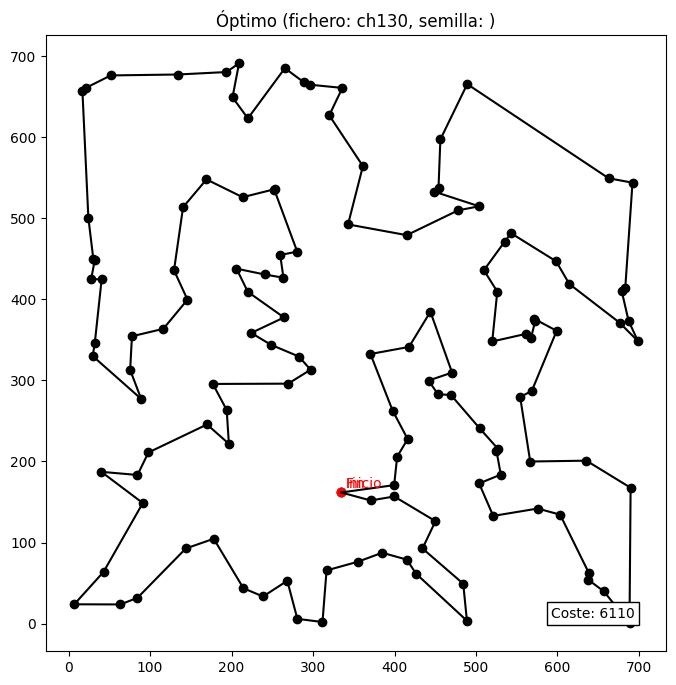

In [61]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
path = leer_path_optimo("tsp/" + fichero_name + ".opt.tour")
path.append(0)

distancias = calcular_distancias(datos_ciudades)
coste = coste_camino(path,distancias)

print("Mejor camino: ", path)
print("Coste camino: ", coste)
representar_mapa(datos_ciudades, path, coste, "Óptimo", fichero_name)

### a280

Mejor camino:  [0, 1, 241, 242, 243, 240, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 245, 244, 246, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212, 211, 210, 209, 206, 205, 204, 203, 202, 201, 200, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 175, 179, 178, 149, 177, 176, 150, 151, 155, 152, 154, 153, 128, 129, 130, 19, 20, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 156, 157, 158, 159, 174, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 170, 172, 173, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 108, 107, 109, 110, 111, 87, 86, 112, 113, 114, 116, 115, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 58, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 21, 24, 22, 23, 13, 14, 12, 11, 10,

  0%|          | 0/20.0 [1:08:06<?, ?s/s]
  0%|          | 0/20.0 [1:06:49<?, ?s/s]
  0%|          | 0/20.0 [1:04:55<?, ?s/s]
  0%|          | 0/20.0 [1:03:46<?, ?s/s]
  0%|          | 0/20.0 [1:03:14<?, ?s/s]
  0%|          | 0/20.0 [1:01:53<?, ?s/s]
  0%|          | 0/20.0 [1:01:31<?, ?s/s]
  0%|          | 0/20.0 [1:01:10<?, ?s/s]
  0%|          | 0/20.0 [47:28<?, ?s/s]
  0%|          | 0/20.0 [30:30<?, ?s/s]


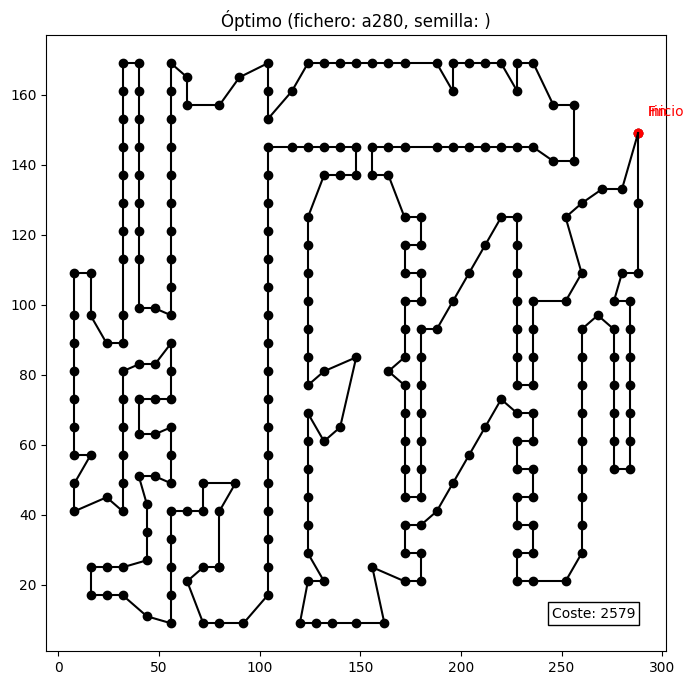

In [62]:
fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
path = leer_path_optimo("tsp/" + fichero_name + ".opt.tour")
path.append(0)

distancias = calcular_distancias(datos_ciudades)
coste = coste_camino(path,distancias)

print("Mejor camino: ", path)
print("Coste camino: ", coste)
representar_mapa(datos_ciudades, path, coste, "Óptimo", fichero_name)

## Algoritmos de Heurísticas Constructivas
Heurísticas Constructivas: Parten de una solución inicial vacía y van añadiéndole componentes hasta construir una solución.

Las heurísticas constructivas son más rápidas pero dan soluciones de peor calidad que la búsqueda local (BL).

Ambos son procesos de búsqueda efectuados sobre un espacio de soluciones al problema. En los métodos constructivos, el espacio es de soluciones parciales, mientras que en la BL es de soluciones completas (candidatas).

El espacio de búsqueda suele ser de un tamaño exponencial con respecto al tamaño del problema.

### Greedy

In [63]:
def greedy(datos_ciudades, distancias):
    start_time = time.time()
    n_evaluaciones = 0

    start_city = 0
    end_city = start_city

    n = len(distancias)
    visited = [False] * n
    path = [start_city]
    visited[start_city] = True
    coste = 0

    for i in range(1,n):
        last_city = path[-1]
        min_distance = float('inf')
        nearest_city = None

        for j in range(n):
            if not visited[j] and distancias[last_city][j] < min_distance:
                min_distance = distancias[last_city][j]
                n_evaluaciones += 1
                nearest_city = j

        visited[nearest_city] = True
        coste += min_distance
        path.append(nearest_city)

    # Añadir la arista que conecta la última ciudad con la primera ciudad
    coste += distancias[path[-1]][end_city]
    path.append(end_city)

    end_time = time.time()

    tiempo= end_time - start_time

    return path, coste, n_evaluaciones, tiempo

### c130

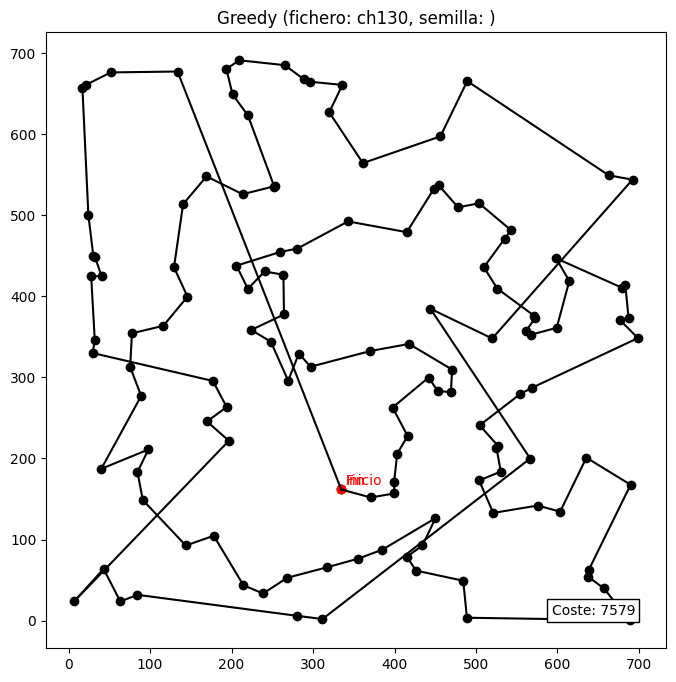

Mejor camino:  [0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0] 
 Distancia recorrida: 7579


In [64]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)
path, coste_greedy_c130, _, _ = greedy(datos_ciudades, distancias)

representar_mapa(datos_ciudades, path, coste_greedy_c130, greedy_name, fichero_name)

print("Mejor camino: ", path, "\n", "Distancia recorrida:", coste_greedy_c130)

### a280

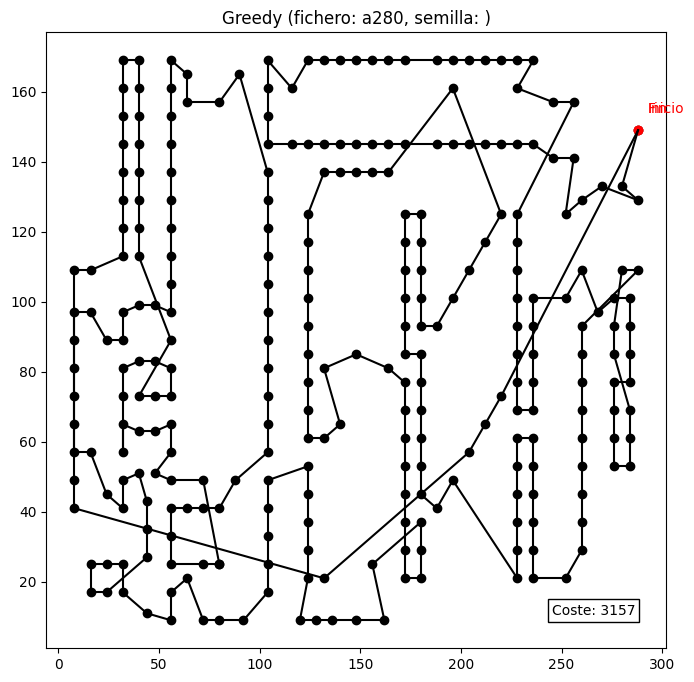

Mejor camino:  [0, 279, 1, 2, 278, 277, 3, 276, 275, 274, 273, 272, 271, 270, 15, 16, 17, 18, 19, 20, 127, 126, 125, 124, 29, 30, 31, 28, 27, 26, 25, 21, 24, 22, 23, 13, 12, 11, 10, 9, 7, 6, 8, 5, 4, 259, 258, 257, 256, 253, 252, 207, 206, 209, 208, 251, 254, 255, 248, 247, 246, 243, 240, 239, 238, 237, 230, 231, 232, 233, 234, 235, 236, 245, 244, 242, 241, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 218, 217, 214, 213, 210, 211, 212, 215, 216, 219, 220, 202, 201, 199, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 14, 132, 131, 130, 129, 128, 153, 154, 152, 155, 151, 150, 176, 175, 180, 179, 178, 177, 149, 148, 147, 146, 145, 144, 198, 197, 196, 193, 194, 195, 200, 192, 191, 190, 189, 188, 187, 186, 184, 183, 182, 181, 160, 161, 162, 163, 164, 165, 166, 167, 168, 100, 99, 98, 97, 92, 93, 94, 95, 96, 91, 90, 89, 88, 80, 79, 78, 75, 74, 73, 72, 71, 70, 69, 66, 65, 64, 63, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36

In [65]:
fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)
path, coste_greedy_a280, _, _ = greedy(datos_ciudades, distancias)

representar_mapa(datos_ciudades, path, coste_greedy_a280, greedy_name, fichero_name)

print("Mejor camino: ", path, "\n", "Distancia recorrida:", coste_greedy_a280)

## Algoritmos de Hurísticas No Constructivas

### Sistema de Hormigas

El sistema de hormigas es una metaheurística que se basa en el comportamiento colectivo de las hormigas reales para resolver problemas de optimización. Se ha utilizado en una amplia gama de aplicaciones, desde problemas de enrutamiento de vehículos hasta planificación de redes y problemas de programación.

En el sistema de hormigas, se simula el comportamiento de las hormigas reales que utilizan feromonas para comunicarse y encontrar caminos óptimos hacia las fuentes de alimento. En lugar de alimento, en el contexto de la optimización, las hormigas buscan soluciones de alta calidad en un espacio de búsqueda.

El sistema de hormigas consta de varias etapas:

1. Inicialización
2. Construcción de soluciones
3. Actualización de feromonas
4. Criterio de parada

El sistema de hormigas tiene varias variantes y enfoques que se han desarrollado a lo largo del tiempo para mejorar su rendimiento y adaptabilidad a diferentes problemas. Algunas de las approaches más comunes incluyen:

- Ant Colony System (ACS): Esta variante introduce una cantidad adicional de feromona llamada "feromona local", que se deposita en el camino seguido por la mejor hormiga en cada iteración. Esto refuerza los caminos más prometedores y mejora la capacidad de búsqueda.
- Max-Min Ant System (MMAS): Esta variante utiliza límites máximo y mínimo para las feromonas. La feromona se mantiene dentro de un rango establecido, evitando que se vuelva demasiado alta o demasiado baja. Esto ayuda a mantener una buena diversidad de soluciones y evita la convergencia prematura.
- Ant Colony Optimization (ACO): Es una versión generalizada del sistema de hormigas que puede aplicarse a diferentes problemas de optimización combinatoria. Se han desarrollado diferentes representaciones y reglas de transición específicas para adaptarse a problemas específicos, como el Problema del Viajante de Comercio (TSP) o el Problema de Ruteo de Vehículos (VRP).

*Dorigo, M., Maniezzo, V., & Colorni, A. (1996). Ant system: optimization by a colony of cooperating agents. IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), 26(1), 29-41.*
*Dorigo, M., & Stützle, T. (2004). Ant colony optimization algorithms for the traveling salesman problem.*

In [74]:
def sistema_hormigas(datos_ciudades, distancias, num_hormigas = 30, tiempo_limite = 60, alpha = 1, beta = 2, rho = 0.1, f0 = 1):
    start_city = 0
    end_city = start_city

    num_ciudades = len(datos_ciudades)
    path_optimo = None
    coste_optimo = float("inf")

    # Inicializar feromonas a valor inicial
    feromonas = np.ones((num_ciudades, num_ciudades)) * f0 / num_ciudades

    path_greedy, coste_greedy, _, _ = greedy(datos_ciudades, distancias)

    # Actualizar feromonas para las hormigas
    for i in range(len(path_greedy) - 1):
        ciudad1 = path_greedy[i]
        ciudad2 = path_greedy[i + 1]
        feromonas[ciudad1, ciudad2] += 1.0 / coste_greedy

    evaluaciones = 0

    tiempo_limite = float(tiempo_limite)
    tiempo_ejecucion_segundos= 0.0

    barra_progreso = tqdm(total=tiempo_limite, leave=True, unit='s')  # Creamos la barra de progreso

    while tiempo_ejecucion_segundos < tiempo_limite:
        tiempo_inicio = time.time()

        # Crear colonia de hormigas
        hormigas = []
        for j in range(num_hormigas):
            ciudad_inicial = int(random.randint(0, num_ciudades-1))
            hormigas.append([ciudad_inicial])

            # Si queremos empezar por la ciudad 0: todas las hormigas a la ciudad 0 en el inicio:
            # hormigas.append([start_city])

        # Recorrer todas las ciudades
        for hormiga in hormigas:
            ciudades_visitadas = set(hormiga)
            while len(ciudades_visitadas) < num_ciudades:
                ciudad_actual = hormiga[-1]
                probabilidad = []
                for ciudad in range(num_ciudades):
                    if ciudad not in ciudades_visitadas:
                        feromona = feromonas[ciudad_actual][ciudad]
                        distancia = distancias[ciudad_actual][ciudad]
                        if distancia == 0:
                            inv = float("inf")
                        else:
                            inv = (1.0 / distancia)
                        probalidad_calculada = feromona**alpha * inv**beta
                        probabilidad.append((ciudad, probalidad_calculada))

                probabilidad = np.array(probabilidad)

                # Numpy para calcular las probabilidades en la ruleta inversa da un error muy común: probabilities do not sum 1, esto puede deberse a diferentes causas pero la principal es el redondeo de probabilidades, en el que la suma de las probabilidades no llegue a dar 1. Por eso se hace una normalización previa, la función np.random.choice verifica que esta suma sea 1 y en el caso de no serlo no se ejecuta, a pesar de tener un número muy cercano a 1. Así, la solución que hay es realizar una normalización previa en donde todas las probabilidades se encuentren entre 0 y 1 y sumen 1.

                # Fuentes:
                # https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html
                # https://stackoverflow.com/questions/46539431/np-random-choice-probabilities-do-not-sum-to-1
                # https://github.com/numpy/numpy/blob/maintenance/1.9.x/numpy/random/mtrand/mtrand.pyx#L1082


                # Ajustar las probabilidades para que estén en el rango [0, 1]
                min_prob = np.min(probabilidad[:, 1])
                max_prob = np.max(probabilidad[:, 1])
                if max_prob - min_prob != 0:
                    probabilidad[:, 1] = (probabilidad[:, 1] - min_prob) / (max_prob - min_prob)
                else:
                    probabilidad[:, 1] = 1.0 / len(probabilidad[:, 1])

                # Además, ante la posibilidad de tener dos ciudades cuya distancia sea 0, esto puede llevar a que en el cálculo la probabilidad sea NaN, por eso se añade esta línea de código en la que se verifica que la probabilidad no sea Nan, si es así se modifica por 1 / n_ciudades (un número constante para estos casos).
                probabilidad[:, 1][np.isnan(probabilidad[:, 1])] = 1.0 / len(probabilidad[:, 1])

                # Redondear los valores de probabilidad
                probabilidad[:, 1] = np.round(probabilidad[:, 1], decimals=2)

                # Ajustar las probabilidades para que sumen 1 después de redondear
                probabilidad[:, 1] = (probabilidad[:, 1] / np.sum(probabilidad[:, 1])).astype(np.float64)
                siguiente_ciudad = int(np.random.choice(probabilidad[:, 0], p=probabilidad[:, 1])) # random choice normaliza y hace la ruleta proporcional no hace falta dividir
                hormiga.append(siguiente_ciudad)
                ciudades_visitadas.add(siguiente_ciudad)

            # Añadir enlace desde la última ciudad visitada hasta la primera
            hormiga.append(hormiga[end_city])

        # Actualizar feromonas
        feromonas *= (1 - rho)

        # Calcular coste y actualizar mejor solución
        for hormiga in hormigas:
            coste = coste_camino(hormiga, distancias)
            evaluaciones += 1

            for i in range(len(hormiga)-1):
                ciudad1 = hormiga[i]
                ciudad2 = hormiga[i+1]
                # Solo se actualiza la feromona de la hormiga que haya encontrado la mejor solución
                # if coste_camino(hormiga, distancias) == coste_optimo:
                feromonas[ciudad1, ciudad2] += 1.0 / coste # de su coste no de coste_optimo
                feromonas[ciudad2, ciudad1] += 1.0 / coste # de su coste no coste_optimo

            if coste < coste_optimo:
                path_optimo = hormiga
                coste_optimo = coste

        tiempo_fin = time.time()
        tiempo_elapsado = tiempo_fin - tiempo_inicio
        tiempo_ejecucion_segundos += tiempo_elapsado

        # Mostrar barra de progreso
        barra_progreso.update(round(tiempo_elapsado))

    barra_progreso.close()

    return path_optimo, coste_optimo, evaluaciones, round(tiempo_ejecucion_segundos,2)

In [67]:
'''fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = 20
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_a280
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

sistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, alpha, beta, rho, f0)'''

'fichero_name = "ch130"\nfichero = \'tsp/\' + fichero_name + \'.tsp\'\ndatos_ciudades = cargar_datos(fichero)\ndistancias = calcular_distancias(datos_ciudades)\n\nnum_hormigas = n_hormigas\ntiempo_limite = 20\na = alpha\nb = beta\nrho = parametro_evaporacion\n\nn = len(datos_ciudades)\nL = coste_greedy_a280\ncantidad_feronoma_0 = 1 / (n * L)\n\nf0 = cantidad_feronoma_0\n\nsistema_hormigas(datos_ciudades, distancias, num_hormigas, tiempo_limite, alpha, beta, rho, f0)'

### Sistema de Hormigas Elitista


El sistema de hormigas elitista es una variante del sistema de hormigas clásico que introduce un componente de elitismo en el proceso de búsqueda y actualización de feromonas. A diferencia del sistema de hormigas estándar, donde todas las hormigas tienen igual probabilidad de ser seleccionadas para actualizar las feromonas, en el sistema de hormigas elitista se da prioridad a las mejores soluciones encontradas hasta el momento.

En el sistema de hormigas elitista, además de mantener una matriz de feromonas que representa la información compartida por las hormigas, también se mantiene un registro de la mejor solución encontrada hasta el momento, conocida como "mejor hormiga" o "hormiga elitista". Esta mejor solución se actualiza cada vez que una hormiga encuentra una solución mejor que la actualmente registrada.

Durante el proceso de búsqueda, las hormigas siguen un comportamiento similar al del sistema de hormigas clásico, construyendo soluciones iterativamente y actualizando las feromonas en función de la calidad de las soluciones encontradas. Sin embargo, cuando se trata de actualizar las feromonas, las hormigas elitistas tienen una mayor probabilidad de ser seleccionadas para realizar esta actualización.

La selección de las hormigas elitistas se basa en la calidad de las soluciones que han construido. Generalmente, se elige un porcentaje fijo de hormigas con las mejores soluciones como hormigas elitistas. Estas hormigas elitistas actualizan las feromonas en los arcos correspondientes a su solución, lo que aumenta la intensidad de la información en esas rutas prometedoras.

El componente de elitismo en el sistema de hormigas elitista permite acelerar el proceso de búsqueda al enfocar más recursos en las áreas más prometedoras del espacio de soluciones. Esto se debe a que las hormigas elitistas tienen una mayor probabilidad de construir soluciones basadas en información de alta calidad, lo que les permite explorar y explotar de manera más efectiva el espacio de búsqueda.

En resumen, el sistema de hormigas elitista combina la exploración global del sistema de hormigas con una explotación más intensiva de las mejores soluciones encontradas hasta el momento. Esta combinación de exploración y explotación mejora la eficiencia y efectividad del algoritmo, permitiendo encontrar soluciones de mayor calidad en un tiempo reducido.

*Dorigo, M., & Gambardella, L. M. (1997). Ant colony system: a cooperative learning approach to the traveling salesman problem. IEEE Transactions on evolutionary computation, 1(1), 53-66.*



In [75]:
def sistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas = 30, tiempo_limite = 60, alpha = 1, beta = 2, rho = 0.1, f0 = 1, n_elitistas = 15):
    num_ciudades = len(datos_ciudades)
    path_optimo = None
    coste_optimo = float("inf")
    path_elitista = None
    coste_elitista = float("inf")

    # Inicializar feromonas a valor inicial
    feromonas = np.ones((num_ciudades, num_ciudades)) * f0 / num_ciudades

    path_greedy, coste_greedy, _, _ = greedy(datos_ciudades, distancias)
    # Actualizar feromonas para las hormigas
    for i in range(len(path_greedy) - 1):
        ciudad1 = path_greedy[i]
        ciudad2 = path_greedy[i + 1]
        feromonas[ciudad1, ciudad2] += 1.0 / coste_greedy

    evaluaciones = 0

    tiempo_limite = float(tiempo_limite)
    tiempo_ejecucion_segundos= 0.0

    barra_progreso = tqdm(total=tiempo_limite, leave=True, unit='s')  # Creamos la barra de progreso

    while tiempo_ejecucion_segundos < tiempo_limite:
        tiempo_inicio = time.time()

        # Crear colonia de hormigas
        hormigas = [[] * num_hormigas]

        # Recorrer todas las ciudades
        for hormiga in hormigas:
            ciudad_inicial = int(random.randint(0, num_ciudades-1))
            hormiga.append(ciudad_inicial)
            end_city = ciudad_inicial

            # Si queremos empezar por la ciudad 0: todas las hormigas a la ciudad 0 en el inicio:
            # hormigas.append([start_city])
            ciudades_visitadas = set(hormiga)
            while len(ciudades_visitadas) < num_ciudades:
                ciudad_actual = hormiga[-1]
                probabilidad = []
                for ciudad in range(num_ciudades):
                    ciudad = int(ciudad)
                    if ciudad not in ciudades_visitadas:
                        feromona = feromonas[ciudad_actual][ciudad]
                        distancia = distancias[ciudad_actual][ciudad]
                        if distancia == 0:
                            inv = float("inf")
                        else:
                            inv = (1.0 / distancia)
                        probalidad_calculada = feromona**alpha * inv**beta
                        probabilidad.append((ciudad, probalidad_calculada))

                probabilidad = np.array(probabilidad)

                # Ajustar las probabilidades para que estén en el rango [0, 1]
                min_prob = np.min(probabilidad[:, 1])
                max_prob = np.max(probabilidad[:, 1])
                if max_prob - min_prob != 0:
                    probabilidad[:, 1] = (probabilidad[:, 1] - min_prob) / (max_prob - min_prob)
                else:
                    probabilidad[:, 1] = 1.0 / len(probabilidad[:, 1])


                probabilidad[:, 1][np.isnan(probabilidad[:, 1])] = 1.0 / len(probabilidad[:, 1])

                # Redondear los valores de probabilidad
                probabilidad[:, 1] = np.round(probabilidad[:, 1], decimals=2)

                # Ajustar las probabilidades para que sumen 1 después de redondear
                probabilidad[:, 1] /= np.sum(probabilidad[:, 1])

                # Elegir la siguiente ciudad aleatoriamente en función de las probabilidades
                # En lugar de elegir aleatoriamente, obtener la ciudad con mayor probabilidad
                #indice_ciudad = np.argmax(probabilidad[:, 1])
                # siguiente_ciudad = int(probabilidad[indice_ciudad, 0])
                siguiente_ciudad = int(np.random.choice(probabilidad[:, 0], p=probabilidad[:, 1]))
                hormiga.append(siguiente_ciudad)
                ciudades_visitadas.add(siguiente_ciudad)

            # Agregar la ciudad 0 al final de la ruta de la hormiga
            hormiga.append(end_city)

        # Ordenar hormigas por coste y seleccionar las n_elitistas mejores
        hormigas.sort(key=lambda x: coste_camino(x, distancias))
        evaluaciones += len(hormigas)

        # Calcular coste y actualizar mejor solución
        path_elitista_actual = hormigas[0]
        coste_elitista_actual = coste_camino(path_elitista_actual, distancias)

        if coste_elitista_actual < coste_optimo:
            path_optimo = path_elitista_actual
            coste_optimo = coste_elitista_actual
        elif coste_elitista_actual < coste_elitista:
            path_elitista = path_elitista_actual
            coste_elitista = coste_elitista_actual

        # Actualizar feromonas path elitista
        feromonas *= (1 - rho)

        if path_elitista is not None:
            for i in range(len(path_elitista)-1):
                ciudad1 = path_elitista[i]
                ciudad2 = path_elitista[i+1]
                feromonas[ciudad1, ciudad2] += (1 / coste_elitista) * n_elitistas
                feromonas[ciudad2, ciudad1] += (1 / coste_elitista) * n_elitistas

        # Actualizar feromonas para las hormigas
        for hormiga in hormigas:
            coste = coste_camino(hormiga, distancias)
            for i in range(len(hormiga) - 1):
                ciudad1 = hormiga[i]
                ciudad2 = hormiga[i + 1]
                feromonas[ciudad1, ciudad2] += 1.0 / coste

        tiempo_fin = time.time()
        tiempo_elapsado = tiempo_fin - tiempo_inicio
        tiempo_ejecucion_segundos += tiempo_elapsado

        # Mostrar barra de progreso
        barra_progreso.update(round(tiempo_elapsado))

    barra_progreso.close()

    return path_optimo, coste_optimo, evaluaciones, round(tiempo_ejecucion_segundos, 2)

In [69]:
'''fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = 20
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_a280
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

n_el = 15

sistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas, tiempo_limite, alpha, beta, rho, f0, n_el)'''

'fichero_name = "ch130"\nfichero = \'tsp/\' + fichero_name + \'.tsp\'\ndatos_ciudades = cargar_datos(fichero)\ndistancias = calcular_distancias(datos_ciudades)\n\nnum_hormigas = n_hormigas\ntiempo_limite = 20\na = alpha\nb = beta\nrho = parametro_evaporacion\n\nn = len(datos_ciudades)\nL = coste_greedy_a280\ncantidad_feronoma_0 = 1 / (n * L)\n\nf0 = cantidad_feronoma_0\n\nn_el = 15\n\nsistema_hormigas_elitista(datos_ciudades, distancias, num_hormigas, tiempo_limite, alpha, beta, rho, f0, n_el)'

## Comparar algoritmos

In [70]:
def comparar_algoritmos(fichero_name, semillas, num_hormigas=30, tiempo_limite=60, alpha=1, beta=2, rho=0.1, f0=1, n_elitistas=15):
    # Cargar datos y calcular distancias
    fichero = 'tsp/' + fichero_name + '.tsp'
    datos_ciudades = cargar_datos(fichero)
    distancias = calcular_distancias(datos_ciudades)

    # Definir algoritmos
    algoritmos = [(greedy_name, greedy, []),
                  (sh_name, sistema_hormigas, [num_hormigas, tiempo_limite, alpha, beta, rho, f0]),
                  (she_name, sistema_hormigas_elitista, [num_hormigas, tiempo_limite, alpha, beta, rho, f0, n_elitistas])]

    # Ejecutar algoritmos para cada semilla
    resultados = []
    for semilla in semillas:
        random.seed(semilla)
        res_semilla = []
        for algoritmo_name, algoritmo, algoritmo_params in algoritmos:
            # Ejecutar algoritmo y guardar coste y evaluaciones
            params = (datos_ciudades, distancias) + tuple(algoritmo_params)
            path_optimo, coste_optimo, evaluaciones, tiempo_ejecucion_segundos = algoritmo(*params)
            res_semilla.append((tiempo_ejecucion_segundos, evaluaciones, coste_optimo))

            print(path_optimo)

            representar_mapa(datos_ciudades, path_optimo, coste_optimo, algorithm_name=algoritmo_name, fichero_name=fichero_name, semilla = semilla)
            '''print("El camino óptimo es:", path_optimo)
            print("El coste óptimo es:", coste_optimo)
            print("El número de evaluaciones es:", evaluaciones)
            print("El tiempo de ejecución es:", tiempo_ejecucion_segundos, " segundos")
            print("\n\n")
            print("=========================================================================================================")
            print("\n\n")'''

        resultados.append(res_semilla)

    # print("\n\n\n\n\n\n")

    # Crear tabla de resultados
    header = ('', greedy_name, '', '', sh_name, '', '', she_name, '', '')
    subheader = ('Ejecución', 'Coste (s)', 'Ev.', 'Sol. Ópt', 'Coste', 'Ev.', 'Sol. Ópt', 'Coste', 'Ev.', 'Sol. Ópt')
    tabla = [header, subheader]
    for i, res in enumerate(resultados):
        fila = [f'Ejecución {i+1}']
        for tiempo_ejecucion_segundos, evaluaciones, coste in res:
            fila.append(f'{tiempo_ejecucion_segundos:.2f}')
            fila.append(str(evaluaciones))
            fila.append(f'{coste:.2f}')
        tabla.append(fila)

    # Calcular la media y desviación típica
    resultados_np = np.array(resultados)
    media = np.mean(resultados_np, axis=0)
    desviacion = np.std(resultados_np, axis=0)

    # Agregar filas a la tabla de resultados
    media_str = ['Media'] + [f'{c:.3f}' for c in media.flatten()]
    desviacion_str = ['Desv. típica'] + [f'{c:.3f}' for c in desviacion.flatten()]
    tabla.append(media_str)
    tabla.append(desviacion_str)

    # Imprimir tabla
    for fila in tabla:
        print('{:^12}'.format(fila[0]), end='|')
        for elem in fila[1:]:
            print('{:^10}'.format(elem), end='|')
        print()


### ch130

[0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0]


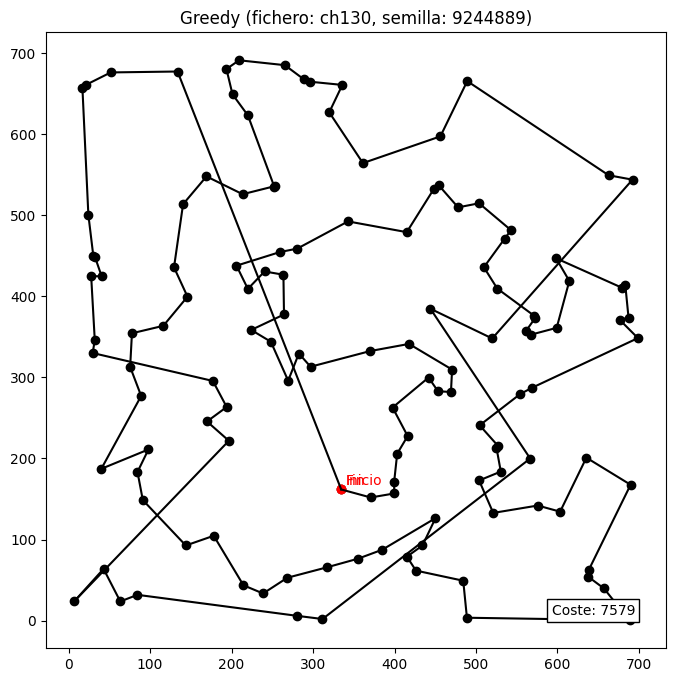

305s [03:00,  1.69s/s]                            


[46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46]


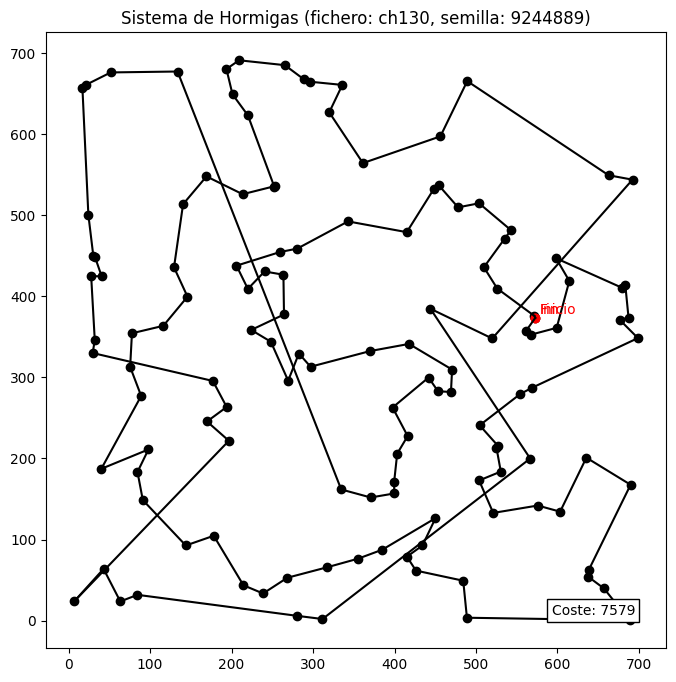

  0%|          | 0/180.0 [03:01<?, ?s/s]


[33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33]


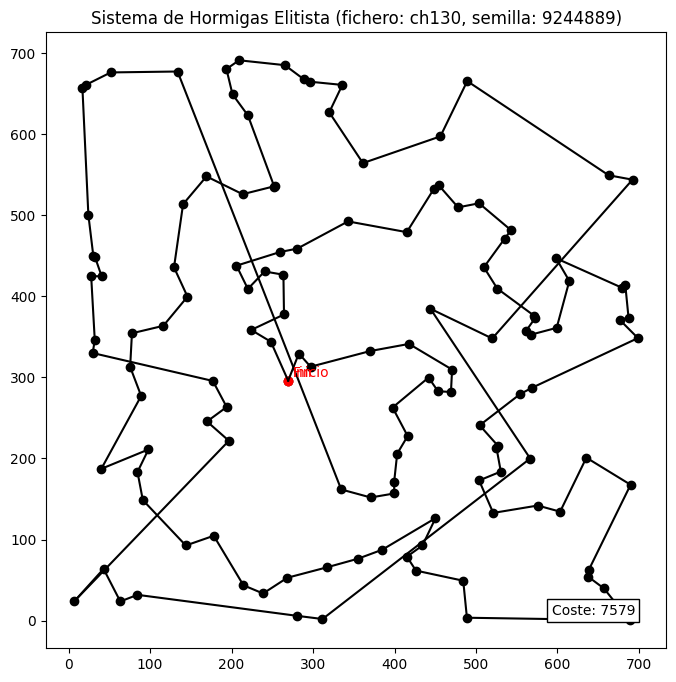

[0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0]


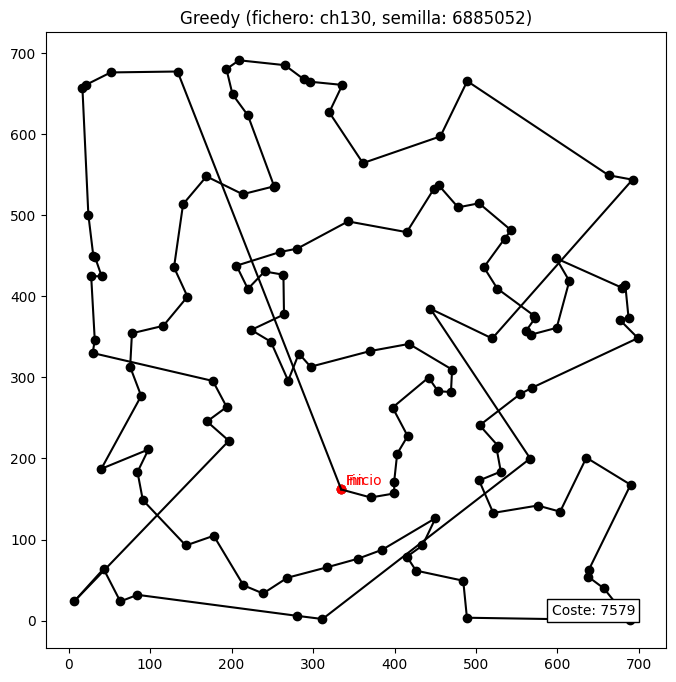

292s [03:00,  1.62s/s]                            


[112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112]


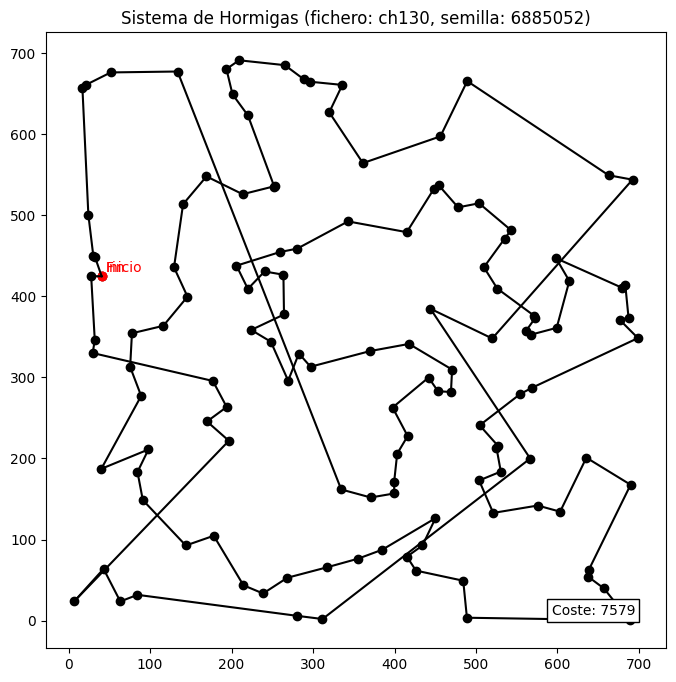

  0%|          | 0/180.0 [03:01<?, ?s/s]


[127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127]


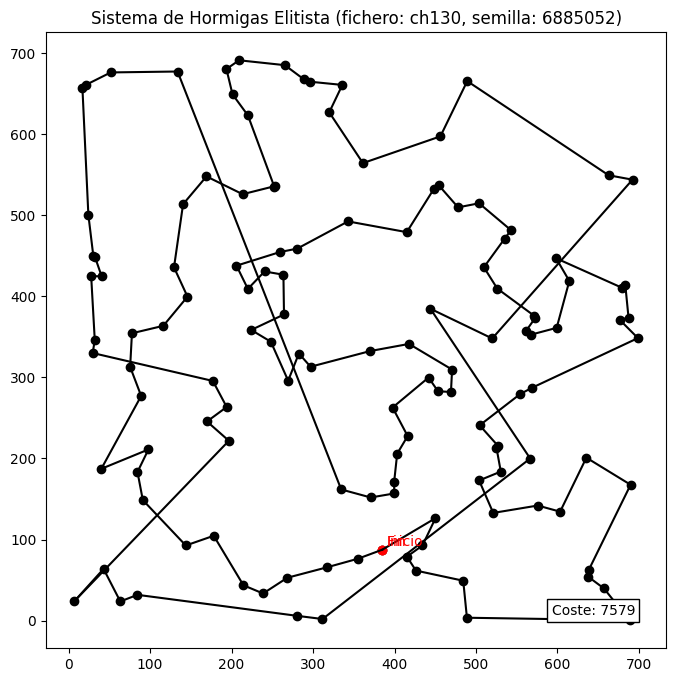

[0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0]


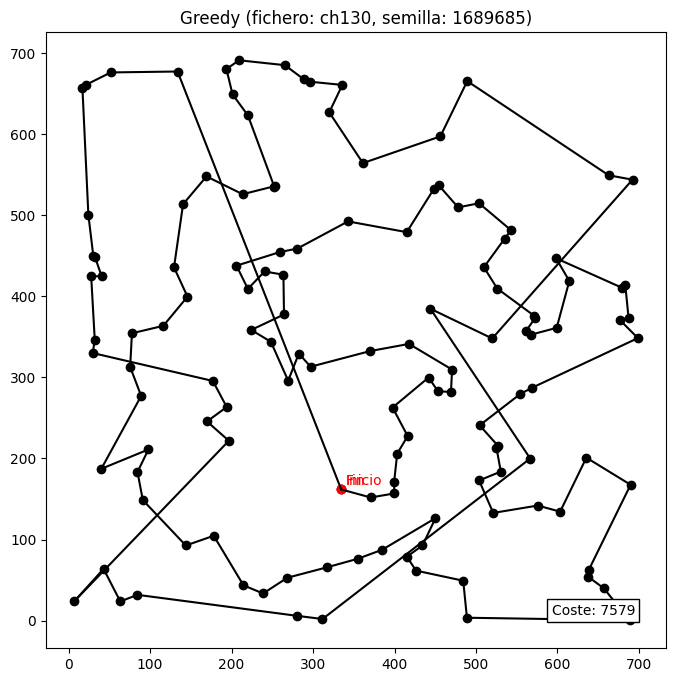

290s [03:00,  1.61s/s]                            


[17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17]


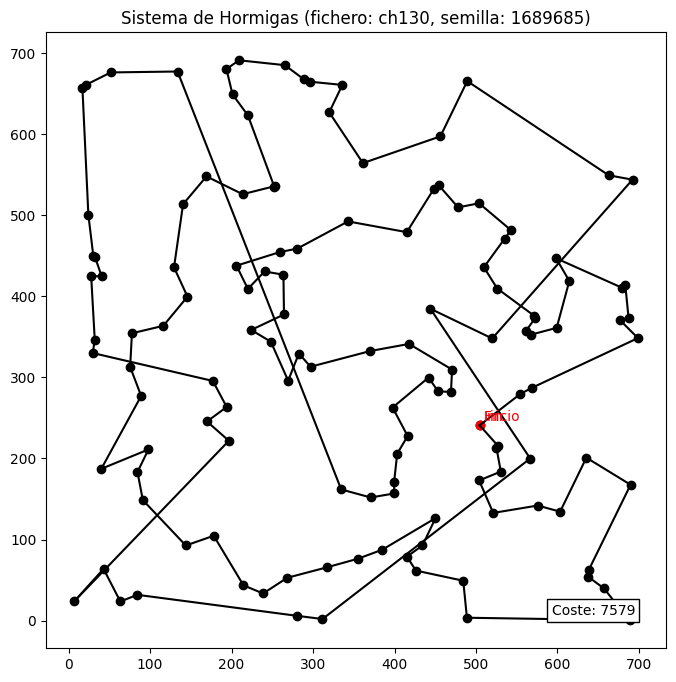

  0%|          | 0/180.0 [03:01<?, ?s/s]


[91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91]


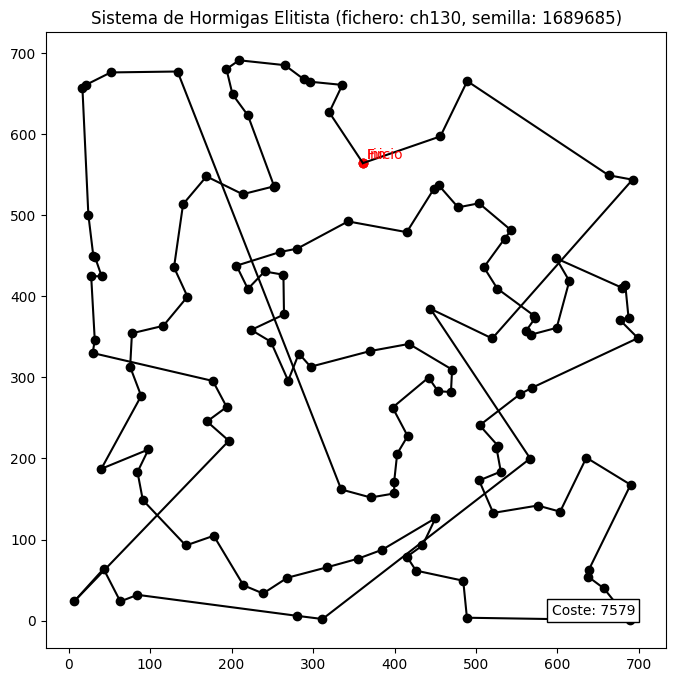

[0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0]


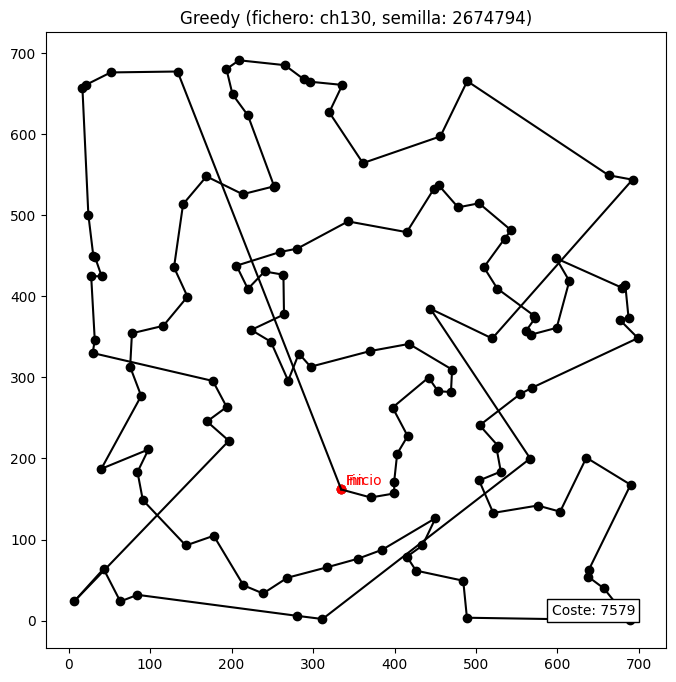

280s [03:00,  1.55s/s]                            


[17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 12, 95, 66, 9, 13, 54, 121, 22, 21, 36, 46, 39, 43, 41, 50, 59, 119, 52, 48, 57, 105, 37, 78, 94, 28, 14, 23, 115, 99, 18, 26, 33, 30, 16, 53, 34, 19, 45, 79, 117, 1, 49, 129, 70, 38, 40, 0, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 3, 92, 32, 20, 125, 17]


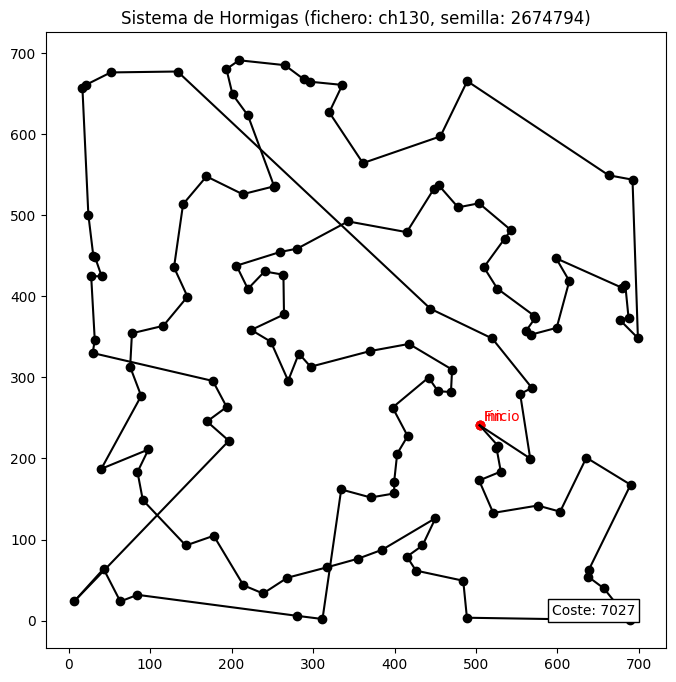

  0%|          | 0/180.0 [03:01<?, ?s/s]


[51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51]


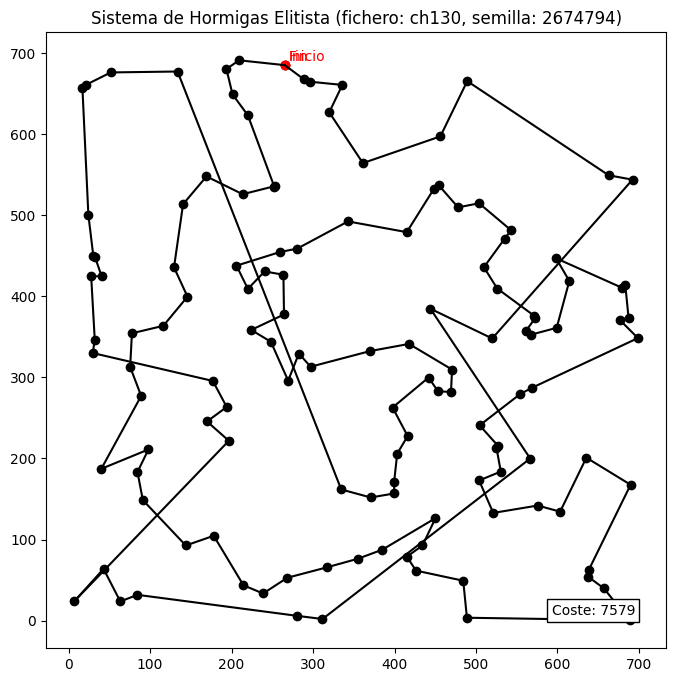

[0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0]


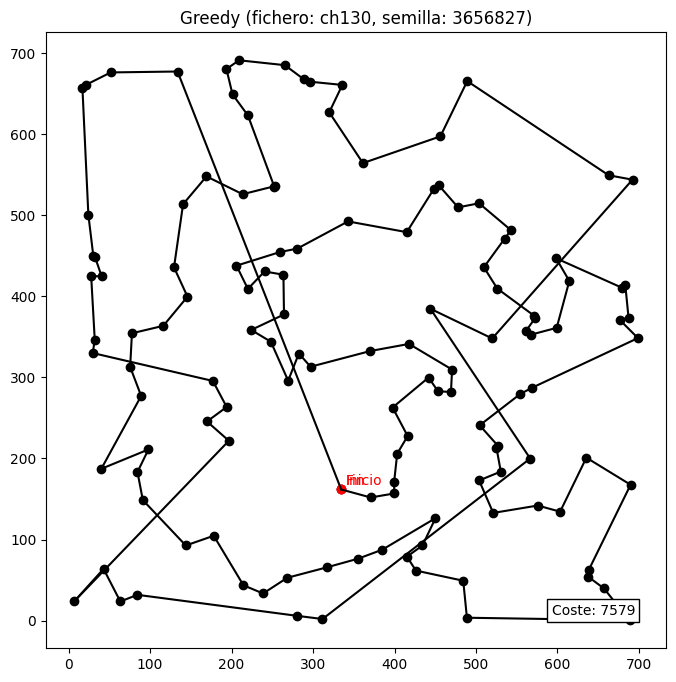

310s [03:00,  1.71s/s]                            


[38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38]


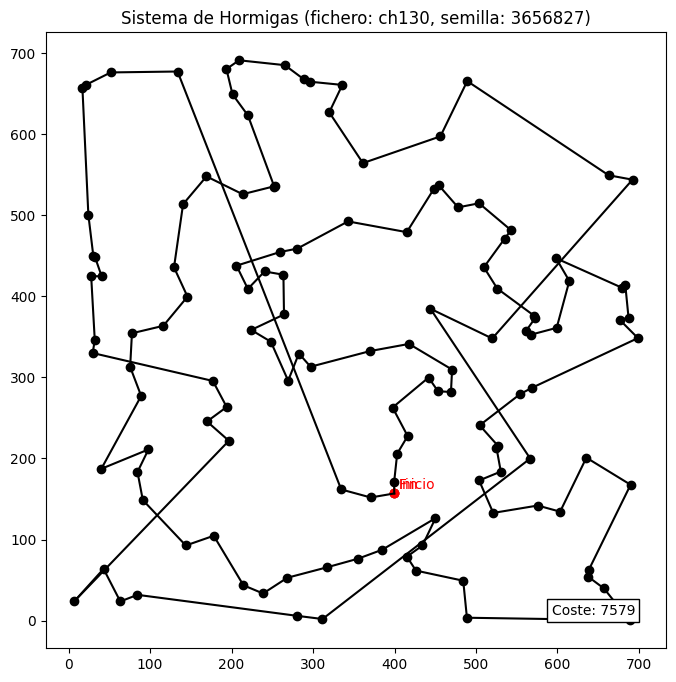

  0%|          | 0/180.0 [03:02<?, ?s/s]


[17, 7, 107, 113, 2, 82, 29, 58, 120, 77, 89, 124, 84, 65, 27, 114, 61, 104, 111, 116, 127, 15, 44, 75, 108, 60, 128, 123, 25, 96, 69, 6, 62, 67, 97, 109, 88, 93, 76, 102, 80, 11, 86, 64, 55, 56, 8, 51, 74, 73, 98, 72, 91, 71, 90, 5, 101, 92, 3, 125, 4, 10, 63, 68, 87, 85, 126, 106, 103, 42, 47, 24, 31, 112, 35, 83, 118, 110, 122, 100, 81, 0, 40, 38, 70, 129, 49, 1, 117, 79, 45, 19, 34, 53, 16, 30, 33, 26, 18, 99, 115, 23, 14, 28, 94, 78, 37, 105, 57, 48, 52, 119, 59, 50, 41, 43, 39, 46, 36, 21, 22, 121, 54, 13, 9, 66, 95, 12, 32, 20, 17]


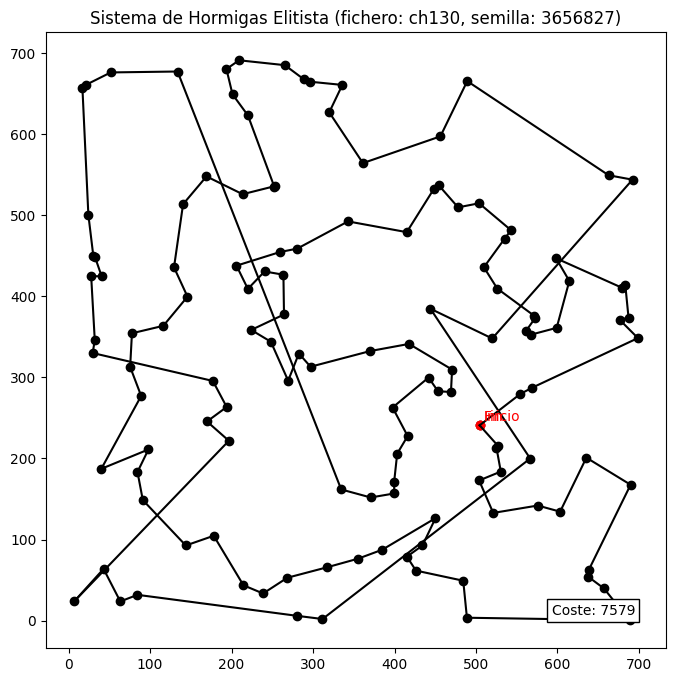

            |  Greedy  |          |          |Sistema de Hormigas|          |          |Sistema de Hormigas Elitista|          |          |
 Ejecución  |Coste (s) |   Ev.    | Sol. Ópt |  Coste   |   Ev.    | Sol. Ópt |  Coste   |   Ev.    | Sol. Ópt |
Ejecución 1 |   0.00   |   528    | 7579.00  |  180.54  |   9150   | 7579.00  |  180.01  |   7929   | 7579.00  |
Ejecución 2 |   0.00   |   528    | 7579.00  |  180.16  |   8760   | 7579.00  |  180.00  |   8180   | 7579.00  |
Ejecución 3 |   0.00   |   528    | 7579.00  |  180.20  |   8730   | 7579.00  |  180.03  |   7203   | 7579.00  |
Ejecución 4 |   0.00   |   528    | 7579.00  |  180.09  |   8400   | 7027.00  |  180.01  |   7902   | 7579.00  |
Ejecución 5 |   0.00   |   528    | 7579.00  |  180.56  |   9300   | 7579.00  |  180.02  |   7130   | 7579.00  |
   Media    |  0.001   | 528.000  | 7579.000 | 180.310  | 8868.000 | 7468.600 | 180.014  | 7668.800 | 7579.000 |
Desv. típica|  0.001   |  0.000   |  0.000   |  0.199   | 321.210  | 

In [71]:
fichero_name = "ch130"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_c130
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_c130
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

tam_elite = n_elitistas

comparar_algoritmos(fichero_name, semillas, num_hormigas=num_hormigas, tiempo_limite=tiempo_limite, alpha=a, beta=b, rho=rho, f0=cantidad_feronoma_0, n_elitistas=tam_elite)

### a280

[0, 279, 1, 2, 278, 277, 3, 276, 275, 274, 273, 272, 271, 270, 15, 16, 17, 18, 19, 20, 127, 126, 125, 124, 29, 30, 31, 28, 27, 26, 25, 21, 24, 22, 23, 13, 12, 11, 10, 9, 7, 6, 8, 5, 4, 259, 258, 257, 256, 253, 252, 207, 206, 209, 208, 251, 254, 255, 248, 247, 246, 243, 240, 239, 238, 237, 230, 231, 232, 233, 234, 235, 236, 245, 244, 242, 241, 249, 250, 229, 228, 227, 226, 225, 224, 223, 222, 221, 218, 217, 214, 213, 210, 211, 212, 215, 216, 219, 220, 202, 201, 199, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 269, 268, 267, 266, 265, 264, 263, 262, 261, 260, 14, 132, 131, 130, 129, 128, 153, 154, 152, 155, 151, 150, 176, 175, 180, 179, 178, 177, 149, 148, 147, 146, 145, 144, 198, 197, 196, 193, 194, 195, 200, 192, 191, 190, 189, 188, 187, 186, 184, 183, 182, 181, 160, 161, 162, 163, 164, 165, 166, 167, 168, 100, 99, 98, 97, 92, 93, 94, 95, 96, 91, 90, 89, 88, 80, 79, 78, 75, 74, 73, 72, 71, 70, 69, 66, 65, 64, 63, 62, 61, 117, 60, 59, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 3

  0%|          | 0/20.0 [4:18:26<?, ?s/s]


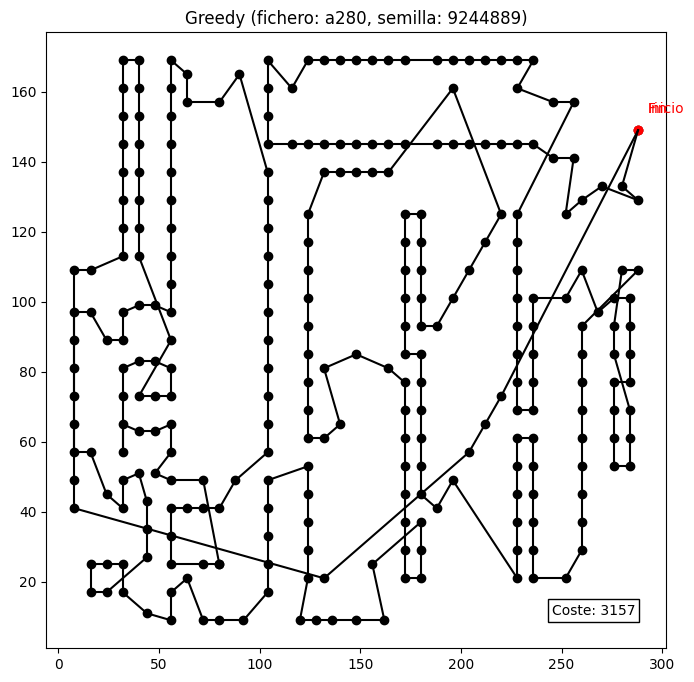


  0%|          | 0/480.0 [00:00<?, ?s/s]C:\Users\albam\AppData\Local\Temp\ipykernel_12892\3447467947.py:70: RuntimeWarning: invalid value encountered in divide
  probabilidad[:, 1] = (probabilidad[:, 1] - min_prob) / (max_prob - min_prob)
C:\Users\albam\AppData\Local\Temp\ipykernel_12892\3447467947.py:81: RuntimeWarning: invalid value encountered in divide
  probabilidad[:, 1] = (probabilidad[:, 1] / np.sum(probabilidad[:, 1])).astype(np.float64)


ValueError: probabilities contain NaN

In [76]:
fichero_name = "a280"
fichero = 'tsp/' + fichero_name + '.tsp'
datos_ciudades = cargar_datos(fichero)
distancias = calcular_distancias(datos_ciudades)

num_hormigas = n_hormigas
tiempo_limite = tiempo_max_a280
a = alpha
b = beta
rho = parametro_evaporacion

n = len(datos_ciudades)
L = coste_greedy_a280
cantidad_feronoma_0 = 1 / (n * L)

f0 = cantidad_feronoma_0

tam_elite = n_elitistas

comparar_algoritmos(fichero_name, semillas, num_hormigas=num_hormigas, tiempo_limite=tiempo_limite, alpha=a, beta=b, rho=rho, f0=cantidad_feronoma_0, n_elitistas=tam_elite)

En el caso de Greedy se obtiene un coste de 0 como es de esperar mientras que en el resto el coste temporal es aproximadamente costante, teniendo en cuenta el tiempo límite puesto.

Con el número de evaluaciones pasa lo mismo en el Greedy y los resultados óptimos son constantes pues el Greedy no depende de heurísticas.

Entre Sistema de Hormigas y Sistemas de Hormigas Elitista es de esperar que el elitista obtenga mejores resultados, no ha sido así, puede que la hormiga elitista se haya centrado en un camino y por lo tanto no se haya conseguido explorar lo suficiente sino explotar.